In [6]:
pip install torch_geometric

In [7]:
pip install torch torchvision torchaudio

In [4]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 33.9 MB/s eta 0:00:00


In [21]:
import os
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data, Dataset, DataLoader
from torch_geometric.nn import global_add_pool
from tqdm import tqdm
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem, rdchem

환경결정상수

In [22]:
# H5 파일 키 설정
KEY_CONFIG = {
    "atoms": "elements", "smiles": "Rsmiles",
    "R_coords": "RG", "TS_coords": "TSG", "P_coords": "PG",          
    "R_energy": { "H": "R_H", "G": "R_F", "E": "R_E" },
    "TS_energy": { "H": "TS_H", "G": "TS_F", "E": "TS_E" },
    "P_energy": { "H": "P_H", "G": "P_F", "E": "P_E" }
}

# 결합 해리 에너지 (BDE) 테이블 (kcal/mol)
BDE_TABLE = {
    (1, 1): 104, (1, 6): 99, (1, 7): 93, (1, 8): 111, (1, 9): 135,
    (6, 6): 83, (6, 7): 73, (6, 8): 86, (6, 9): 116,
    (7, 7): 39, (7, 8): 53, (8, 8): 35
}

# 원자 물성 [EN, Hardness, Radius, IE]
ATOM_PROPS_TABLE = {
    1: [2.20, 6.42, 0.31, 13.60], 6: [2.55, 5.00, 0.76, 11.26],
    7: [3.04, 7.27, 0.71, 14.53], 8: [3.44, 6.08, 0.66, 13.62], 9: [3.98, 7.01, 0.57, 17.42]
}
DEFAULT_PROPS = [0.0, 0.0, 0.0, 0.0]

# 작용기 SMARTS 패턴
FUNCTIONAL_GROUPS = {
    "Nitro": "[N+](=O)[O-]", "Sulfonyl": "S(=O)(=O)", "Cyano": "C#N", "Trifluoromethyl": "C(F)(F)F",
    "Carbonyl": "[CX3]=[OX1]", "Carboxyl": "[CX3](=O)[OX2H1]", "Halogen": "[F,Cl,Br,I]",
    "Amine": "[NX3;H2,H1,H0;!$(NC=O)]", "Hydroxy": "[OX2H]", "Alkoxy": "[OX2][CX4]", 
    "Amide": "[NX3][CX3](=O)", "Alkyl": "[CX4]", "Phenyl": "c1ccccc1"
}
FG_TYPE_MAP = {
    "Nitro": -1.0, "Sulfonyl": -1.0, "Cyano": -1.0, "Trifluoromethyl": -1.0,
    "Carbonyl": -0.5, "Carboxyl": -0.5, "Halogen": -0.2, "Amine": 1.0, "Hydroxy": 1.0, 
    "Alkoxy": 1.0, "Amide": 0.2, "Alkyl": 0.3, "Phenyl": 0.1
}

데이터셋

In [23]:
class ReactionDataset(Dataset):
    def __init__(self, h5_path, limit=None):
        super().__init__()
        self.h5_path = h5_path
        if not os.path.exists(h5_path): raise FileNotFoundError(f"File not found: {h5_path}")
        with h5py.File(self.h5_path, 'r') as f:
            self.keys = list(f.keys())
            if limit: self.keys = self.keys[:limit]
            self.len_data = len(self.keys)
        self.fg_patterns = {name: Chem.MolFromSmarts(smarts) for name, smarts in FUNCTIONAL_GROUPS.items()}

    def len(self): return self.len_data

    def get_atom_features(self, mol):
        try: AllChem.ComputeGasteigerCharges(mol); 
        except: 
            pass
        features, hsab_list = [], []
        
        atom_fg_info = {atom.GetIdx(): {'ewg':0.0, 'edg':0.0, 'types':[]} for atom in mol.GetAtoms()}
        for name, pattern in self.fg_patterns.items():
            if pattern:
                for match in mol.GetSubstructMatches(pattern):
                    effect = FG_TYPE_MAP.get(name, 0.0)
                    for idx in match:
                        if effect < 0: atom_fg_info[idx]['ewg'] += abs(effect)
                        elif effect > 0: atom_fg_info[idx]['edg'] += effect
                        atom_fg_info[idx]['types'].append(name)
        
        atoms_with_map = [(a.GetAtomMapNum() if a.GetAtomMapNum()!=0 else a.GetIdx()+1, a) for a in mol.GetAtoms()]
        atoms_with_map.sort(key=lambda x: x[0])
        
        for _, atom in atoms_with_map:
            feat = []
            z = atom.GetAtomicNum()
            idx = atom.GetIdx()
            sym_map={'H':0,'C':1,'N':2,'O':3,'F':4}; oh=[0]*6; oh[sym_map.get(atom.GetSymbol(),5)]=1; feat.extend(oh)
            hyb=atom.GetHybridization(); hyb_map={rdchem.HybridizationType.SP:0, rdchem.HybridizationType.SP2:1, rdchem.HybridizationType.SP3:2, rdchem.HybridizationType.SP3D:3, rdchem.HybridizationType.SP3D2:4}; hyb_vec=[0]*5; 
            if hyb in hyb_map: hyb_vec[hyb_map[hyb]]=1
            feat.extend(hyb_vec)
            try: q=float(atom.GetProp('_GasteigerCharge')); 
            except: q=0.0
            if np.isnan(q): q=0.0
            feat.extend([q, float(atom.GetFormalCharge()), float(atom.GetTotalValence()), atom.GetMass()/20.0])
            feat.extend([1.0 if atom.IsInRingSize(s) else 0.0 for s in [3,4,5,6]])
            feat.extend([1.0 if atom.GetIsAromatic() else 0.0, 1.0 if atom.GetChiralTag()!=rdchem.ChiralType.CHI_UNSPECIFIED else 0.0])
            info = atom_fg_info[idx]
            feat.extend([info['ewg'], info['edg'], 1.0 if 'Nitro' in info['types'] or 'Sulfonyl' in info['types'] else 0.0, 1.0 if 'Carbonyl' in info['types'] else 0.0, 1.0 if 'Amine' in info['types'] or 'Hydroxy' in info['types'] else 0.0, 1.0 if 'Halogen' in info['types'] else 0.0])
            features.append(feat)
            props = ATOM_PROPS_TABLE.get(z, DEFAULT_PROPS)
            hsab_list.append([-props[0], props[1]])
        return torch.tensor(features, dtype=torch.float), torch.tensor(hsab_list, dtype=torch.float)

    def get(self, idx):
        with h5py.File(self.h5_path, 'r') as f:
            group = f[self.keys[idx]]
            if KEY_CONFIG["smiles"] in group:
                smi = group[KEY_CONFIG["smiles"]][()]; smi = smi.decode('utf-8') if isinstance(smi, bytes) else str(smi)
                mol = Chem.MolFromSmiles(smi)
                if mol: mol = Chem.AddHs(mol); x, hsab = self.get_atom_features(mol)
                else: atoms = group[KEY_CONFIG["atoms"]][()]; x = torch.zeros(len(atoms), 27); hsab = torch.zeros(len(atoms), 2)
            else: atoms = group[KEY_CONFIG["atoms"]][()]; x = torch.zeros(len(atoms), 27); hsab = torch.zeros(len(atoms), 2)
            pos_R = torch.tensor(group[KEY_CONFIG["R_coords"]][()], dtype=torch.float)
            pos_TS = torch.tensor(group[KEY_CONFIG["TS_coords"]][()], dtype=torch.float)
            pos_P = torch.tensor(group[KEY_CONFIG["P_coords"]][()], dtype=torch.float)
            e_R = torch.tensor([group[KEY_CONFIG["R_energy"][k]][()] for k in ["H","G","E"]], dtype=torch.float)
            e_TS = torch.tensor([group[KEY_CONFIG["TS_energy"][k]][()] for k in ["H","G","E"]], dtype=torch.float)
            e_P = torch.tensor([group[KEY_CONFIG["P_energy"][k]][()] for k in ["H","G","E"]], dtype=torch.float)
            y_fwd = (e_TS - e_R).unsqueeze(0); y_rev = (e_TS - e_P).unsqueeze(0); thermo = (e_P - e_R).unsqueeze(0)
            if x.size(0)!=pos_R.size(0): m=min(x.size(0),pos_R.size(0)); x=x[:m]; hsab=hsab[:m]; pos_R=pos_R[:m]; pos_P=pos_P[:m]; pos_TS=pos_TS[:m]
            n=x.size(0); r=torch.arange(n).repeat_interleave(n); c=torch.arange(n).repeat(n); mask=r!=c
            edge_index=torch.stack([r[mask], c[mask]], dim=0)
            sym=torch.argmax(x[:,:6], dim=1); map_z={0:1,1:6,2:7,3:8,4:9,5:0}; z=torch.tensor([map_z.get(i.item(),0) for i in sym], dtype=torch.long)
            bde = [BDE_TABLE.get(tuple(sorted((int(z[i]), int(z[j])))), 80.0) for i,j in edge_index.T]
            edge_bde = torch.tensor(bde, dtype=torch.float).unsqueeze(-1)
            return Data(x=x, z=z, hsab=hsab, pos=pos_R, pos_P=pos_P, edge_index=edge_index, y_fwd=y_fwd, y_rev=y_rev, y_pos=pos_TS, thermo_energy=thermo, edge_bde=edge_bde)

GNN Backbone

In [24]:
class RBFLayer(nn.Module):
    """
    [Radial Basis Function Layer]
    거리 정보를 단순히 하나의 숫자가 아닌, 여러 개의 기저 함수(Gaussian)로 확장하여 표현합니다.
    이는 Geometric Deep Learning (SchNet, DimeNet)의 핵심 요소입니다.
    """
    def __init__(self, num_rbf=50, cutoff=5.0):
        super().__init__()
        self.cutoff = cutoff
        # 0 ~ cutoff 사이를 num_rbf 개수만큼 등분
        self.centers = nn.Parameter(torch.linspace(0, cutoff, num_rbf), requires_grad=False)
        self.widths = nn.Parameter(torch.tensor([cutoff / num_rbf] * num_rbf), requires_grad=False)

    def forward(self, dist):
        # Gaussian Smearing: exp(- (d - mu)^2 / beta)
        return torch.exp(-((dist - self.centers) ** 2) / self.widths)

In [25]:
class GeometricGNN(nn.Module):
    """
    [Main Backbone]
    위상학적 정보뿐만 아니라 기하학적(RBF) 정보를 적극 활용하는 GNN입니다.
    """
    def __init__(self, node_dim, hidden_dim, num_layers=4):
        super().__init__()
        self.node_emb = nn.Linear(node_dim, hidden_dim)
        self.rbf = RBFLayer(num_rbf=50, cutoff=10.0)
        self.layers = nn.ModuleList([
            GeometricInteractionLayer(hidden_dim, num_rbf=50) for _ in range(num_layers)
        ])

    def forward(self, x, pos, edge_index):
        h = self.node_emb(x)
        
        # 거리 계산 및 RBF 변환
        row, col = edge_index
        dist = (pos[row] - pos[col]).norm(dim=-1, keepdim=True)
        rbf_feat = self.rbf(dist) # [E, 50]
        
        for layer in self.layers:
            h = layer(h, edge_index, rbf_feat)
            
        return h

In [26]:
class GeometricCrossAttention(nn.Module):
    """
    [NEW] Geometric Structure-Aware Attention
    단순 Gating 대신, 거리 정보(RBF)가 Attention Score에 직접 편향(Bias)으로 작용하여
    원자 간 기하학적 상호작용을 정밀하게 학습합니다.
    """
    def __init__(self, hidden_dim, num_heads=4):
        super().__init__()
        self.num_heads = num_heads
        self.scale = (hidden_dim // num_heads) ** -0.5
        
        self.q_proj = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.k_proj = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.v_proj = nn.Linear(hidden_dim, hidden_dim, bias=False)
        
        # 기하학적 정보(RBF)를 Attention Bias로 변환
        self.rbf_proj = nn.Sequential(
            nn.Linear(50, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, num_heads)
        )
        self.out_proj = nn.Linear(hidden_dim, hidden_dim)
        self.norm = nn.LayerNorm(hidden_dim)

    def forward(self, h, edge_index, rbf_feat):
        row, col = edge_index
        # Multi-Head Split
        Q = self.q_proj(h).view(-1, self.num_heads, h.size(-1) // self.num_heads)
        K = self.k_proj(h).view(-1, self.num_heads, h.size(-1) // self.num_heads)
        V = self.v_proj(h).view(-1, self.num_heads, h.size(-1) // self.num_heads)
        
        # Attention Score (Scaled Dot-Product)
        Q_i = Q[row]; K_j = K[col]
        attn_score = (Q_i * K_j).sum(dim=-1) * self.scale
        
        # Geometric Bias Injection (핵심: 거리가 Attention 확률에 영향)
        geom_bias = self.rbf_proj(rbf_feat)
        attn_score = attn_score + geom_bias
        
        # Softmax-like gating
        attn_weights = torch.sigmoid(attn_score).unsqueeze(-1)
        
        # Aggregation
        weighted_msg = (V[col] * attn_weights).view(-1, self.num_heads * (h.size(-1) // self.num_heads))
        out = self.out_proj(weighted_msg)
        
        # Residual Update
        aggr = torch.zeros_like(h)
        aggr.index_add_(0, row, out)
        return self.norm(h + aggr)

In [27]:
class SigmoidGating(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.gate_mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2 + 1, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, 1), nn.Sigmoid()
        )
    def forward(self, h, edge_index, pos):
        row, col = edge_index
        dist = (pos[row] - pos[col]).norm(dim=-1, keepdim=True)
        return self.gate_mlp(torch.cat([h[row], h[col], dist], dim=-1))

In [28]:
class StructureDecoder(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.mlp = nn.Sequential(nn.Linear(hidden_dim*2, hidden_dim), nn.SiLU(), nn.Linear(hidden_dim, 1))
    def forward(self, h, edge_index, gate_score):
        row, col = edge_index
        return self.mlp(torch.cat([h[row], h[col]], dim=-1)) * gate_score

물리법칙

In [29]:
class PaulingBondLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.r0_table = torch.tensor([0.0, 0.31, 0.0, 0.0, 0.0, 0.0, 0.76, 0.71, 0.66, 0.57]) 
    def forward(self, z, edge_index, dist):
        row, col = edge_index
        r0_i = self.r0_table.to(z.device)[z[row]]
        r0_j = self.r0_table.to(z.device)[z[col]]
        r0_sum = (r0_i + r0_j).unsqueeze(-1)
        return torch.exp((r0_sum - dist) / 0.3)

In [30]:
class StereoelectronicLayer(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, pos_R, pos_P, edge_index):
        row, col = edge_index
        vec_R = F.normalize(pos_R[col] - pos_R[row], p=2, dim=-1)
        vec_P = F.normalize(pos_P[col] - pos_P[row], p=2, dim=-1)
        return (vec_R * vec_P).sum(dim=-1, keepdim=True)

In [31]:
class HSABInteractionLayer(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, hsab, edge_index):
        row, col = edge_index
        mu, eta = hsab[:, 0], hsab[:, 1]
        d_mu = (mu[row] - mu[col]).pow(2)
        sum_eta = eta[row] + eta[col]
        return (d_mu / (sum_eta + 1e-6)).unsqueeze(-1)

In [32]:
class StericLayer(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, pos, edge_index):
        row, col = edge_index
        dist = (pos[row] - pos[col]).norm(dim=-1)
        density = 1.0 / (dist.pow(2) + 0.1)
        steric = torch.zeros(pos.size(0), 1, device=pos.device)
        steric.index_add_(0, row, density.unsqueeze(-1))
        return steric

In [33]:
class HammondGate(nn.Module):
    def __init__(self):
        super().__init__()
        self.gate = nn.Sequential(nn.Linear(3, 16), nn.SiLU(), nn.Linear(16, 1), nn.Sigmoid())
    def forward(self, thermo): return self.gate(thermo)

In [34]:
class AdaptiveBEPLayer(nn.Module):
    """
    [NEW] Bell-Evans-Polanyi (BEP) Principle Layer
    E_a = alpha * Delta_H + beta
    분자 전체의 특징을 보고 alpha(기울기)와 beta(절편)를 스스로 조절합니다.
    """
    def __init__(self, hidden_dim):
        super().__init__()
        self.coef_net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.SiLU(),
            nn.Linear(hidden_dim // 2, 2) # [alpha, beta]
        )
        
    def forward(self, h_graph, delta_H):
        coefs = self.coef_net(h_graph)
        alpha = torch.sigmoid(coefs[:, 0:1]) # 0~1 사이 (일반적인 BEP 기울기)
        beta = F.softplus(coefs[:, 1:2])     # 항상 양수 (최소 에너지 장벽)
        return alpha * delta_H + beta

In [35]:
class AdaptiveVSEPRStericLayer(nn.Module):
    """
    [NEW] VSEPR & Steric Effect Layer
    단순 공간 점유뿐만 아니라, 결합 벡터의 비대칭성(VSEPR Strain)을 고려합니다.
    """
    def __init__(self, hidden_dim):
        super().__init__()
        self.vsepr_mlp = nn.Sequential(nn.Linear(1, hidden_dim // 2), nn.SiLU(), nn.Linear(hidden_dim // 2, 1))
        self.steric_mlp = nn.Sequential(nn.Linear(1, hidden_dim // 2), nn.SiLU(), nn.Linear(hidden_dim // 2, 1))
        self.adaptive_gate = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2), nn.SiLU(),
            nn.Linear(hidden_dim // 2, 2), nn.Softmax(dim=-1)
        )

    def forward(self, pos, edge_index, h, batch):
        row, col = edge_index
        # 1. Classical Steric (Crowding)
        dist = (pos[row] - pos[col]).norm(dim=-1)
        density = 1.0 / (dist.pow(2) + 0.1)
        steric_val = torch.zeros(pos.size(0), 1, device=pos.device)
        steric_val.index_add_(0, row, density.unsqueeze(-1))
        
        # 2. VSEPR Strain (Vector Sum Norm)
        vec = F.normalize(pos[col] - pos[row], p=2, dim=-1)
        vec_sum = torch.zeros(pos.size(0), 3, device=pos.device)
        vec_sum.index_add_(0, row, vec)
        vsepr_strain = vec_sum.norm(dim=-1, keepdim=True)
        
        # 3. Adaptive Combination
        weights = self.adaptive_gate(h)
        return weights[:, 0:1] * self.steric_mlp(steric_val) + weights[:, 1:2] * self.vsepr_mlp(vsepr_strain)

Predictor

In [36]:
class PhysChemInformedPredictor(nn.Module):
    def __init__(self, hidden_dim, dropout=0.1):
        super().__init__()
        self.pauling = PaulingBondLayer()
        self.stereo = StereoelectronicLayer()
        self.hsab = HSABInteractionLayer()
        # [Updated] Use Adaptive VSEPR
        self.steric = AdaptiveVSEPRStericLayer(hidden_dim)
        self.hammond = HammondGate()
        # [Updated] Use Adaptive BEP
        self.bep_layer = AdaptiveBEPLayer(hidden_dim)
        
        self.node_mlp = nn.Sequential(nn.Linear(hidden_dim + 4, hidden_dim), nn.SiLU(), nn.Dropout(dropout), nn.Linear(hidden_dim, 3))
        edge_in = (hidden_dim * 2) + 11
        self.edge_mlp = nn.Sequential(nn.Linear(edge_in, hidden_dim), nn.SiLU(), nn.Dropout(dropout), nn.Linear(hidden_dim, hidden_dim), nn.SiLU(), nn.Linear(hidden_dim, 6))
        
        # Residual Learning for Deviation from BEP
        self.residual_mlp = nn.Sequential(nn.Linear(edge_in, hidden_dim), nn.SiLU(), nn.Dropout(dropout), nn.Linear(hidden_dim, hidden_dim), nn.SiLU(), nn.Linear(hidden_dim, 1))

    def forward(self, h, z, hsab, edge_index, pos_R, pos_P, gate_score, pred_delta_D, batch, thermo, bde):
        row, col = edge_index
        late_char = self.hammond(thermo); late_char_edge = late_char[batch[row]]
        
        # Physics Features
        vsepr_steric_R = self.steric(pos_R, edge_index, h, batch)
        vsepr_graph = global_add_pool(vsepr_steric_R, batch)
        h_graph = global_add_pool(h, batch)
        
        # BEP Calculation (Baseline)
        delta_H = thermo[:, 0:1] # Enthalpy
        E_bep_base = self.bep_layer(h_graph, delta_H)
        
        # Base Node Energy
        base = self.node_mlp(torch.cat([h_graph, thermo, vsepr_graph], dim=-1))
        
        # Edge Features
        dist_R = (pos_R[row]-pos_R[col]).norm(dim=-1, keepdim=True)
        dist_P = (pos_P[row]-pos_P[col]).norm(dim=-1, keepdim=True)
        bo_R = self.pauling(z, edge_index, dist_R); bo_P = self.pauling(z, edge_index, dist_P)
        bo_TS = (1.0 - late_char_edge) * bo_R + late_char_edge * bo_P
        align = self.stereo(pos_R, pos_P, edge_index); hsab_E = self.hsab(hsab, edge_index)
        
        edge_feat = torch.cat([h[row], h[col], dist_R, dist_P, gate_score, bo_R, bo_P, bo_TS, bde, align, late_char_edge, hsab_E, pred_delta_D], dim=-1)
        
        # Residual Calculation
        E_residual = self.residual_mlp(edge_feat) * gate_score
        E_residual_sum = global_add_pool(E_residual, batch[row])
        
        # [Final Constraint] Hess's Law Enforcement
        # E_fwd = BEP_Base + Residual
        # E_rev = E_fwd - Delta_H
        E_fwd_pred = E_bep_base + E_residual_sum
        E_rev_pred = E_fwd_pred - delta_H
        
        return E_fwd_pred, E_rev_pred, late_char

Model

In [37]:
class BEPGeoModel(nn.Module):
    """
    [Final Model]
    - Backbone: Geometric Cross Attention (Structure-Aware)
    - Head: Adaptive BEP Principle + VSEPR Steric
    """
    def __init__(self, node_dim=27, hidden_dim=256, num_layers=4):
        super().__init__()
        self.node_emb = nn.Linear(node_dim, hidden_dim)
        self.rbf = RBFLayer(num_rbf=50, cutoff=10.0)
        
        # [Updated] Using Geometric Attention instead of simple GCP
        self.layers = nn.ModuleList([GeometricCrossAttention(hidden_dim, num_heads=4) for _ in range(num_layers)])
        
        self.gating = SigmoidGating(hidden_dim)
        self.struct_decoder = StructureDecoder(hidden_dim)
        self.energy_predictor = PhysChemInformedPredictor(hidden_dim)

    def forward(self, data):
        h = self.node_emb(data.x)
        row, col = data.edge_index
        dist = (data.pos[row] - data.pos[col]).norm(dim=-1, keepdim=True)
        rbf_feat = self.rbf(dist)
        
        # Attention Backbone
        for layer in self.layers: 
            h = layer(h, data.edge_index, rbf_feat)
            
        gate_map = self.gating(h, data.edge_index, data.pos)
        pred_delta_D = self.struct_decoder(h, data.edge_index, gate_map)
        
        thermo_sq = data.thermo_energy.squeeze(1) 
        pred_fwd, pred_rev, ts_char = self.energy_predictor(
            h, data.z, data.hsab, data.edge_index, data.pos, data.pos_P,
            gate_map, pred_delta_D, data.batch, thermo_sq, data.edge_bde
        )
        return pred_delta_D, pred_fwd, pred_rev, gate_map, ts_char

학습루프

In [38]:
def train(h5_path, epochs=40, limit=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")
    
    # Dataset Load
    try:
        dataset = ReactionDataset(h5_path, limit=limit)
    except NameError:
        print("Dataset/Model classes not defined.")
        return None, None, None
    
    loader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    # Model Init
    model = BEPGeoModel(node_dim=27, hidden_dim=256, num_layers=4).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4)
    
    history = {'loss': []}
    real_E3, pred_E3 = {'H':[], 'G':[], 'E':[]}, {'H':[], 'G':[], 'E':[]}
    HARTREE_TO_KCAL = 627.5

    print("\n[Start Training: BEP + Geometric Attention]")
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")
        
        for batch in pbar:
            batch = batch.to(device)
            optimizer.zero_grad()
            
            # Data Preparation (Enthalpy H is index 0)
            target_fwd = (batch.y_fwd.squeeze(1) * HARTREE_TO_KCAL)[:, 0:1]
            target_rev = (batch.y_rev.squeeze(1) * HARTREE_TO_KCAL)[:, 0:1]
            thermo_kcal = batch.thermo_energy.squeeze(1) * HARTREE_TO_KCAL
            
            pred_d, pred_fwd, pred_rev, gate, ts_char = model(batch)
            
            # Loss Calculation
            dist_R = (batch.pos[batch.edge_index[0]] - batch.pos[batch.edge_index[1]]).norm(dim=-1, keepdim=True)
            dist_TS = (batch.y_pos[batch.edge_index[0]] - batch.y_pos[batch.edge_index[1]]).norm(dim=-1, keepdim=True)
            
            l_struct = F.smooth_l1_loss(pred_d, dist_TS - dist_R)
            l_gate = F.binary_cross_entropy(gate, (torch.abs(dist_TS - dist_R)>0.1).float())
            l_fwd = F.smooth_l1_loss(pred_fwd, target_fwd)
            l_rev = F.smooth_l1_loss(pred_rev, target_rev)
            
            # Note: Hess's Law check (Optional, since architecturally enforced)
            # l_hess = F.mse_loss(pred_fwd - pred_rev, thermo_kcal[:, 0:1]) 
            
            total_loss = l_struct + l_gate + l_fwd + l_rev
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            epoch_loss += total_loss.item()
            pbar.set_postfix({'Loss': f"{total_loss.item():.4f}"})
            
            # Collect Stats (Last Epoch)
            if epoch == epochs - 1:
                r = target_fwd.detach().cpu().numpy()
                p = pred_fwd.detach().cpu().numpy()
                # Store only H for this model logic
                real_E3['H'].extend(r[:, 0])
                pred_E3['H'].extend(p[:, 0])
                # Dummy fill for G, E to prevent plotting errors if user plots all 3
                real_E3['G'].extend(r[:, 0]); pred_E3['G'].extend(p[:, 0])
                real_E3['E'].extend(r[:, 0]); pred_E3['E'].extend(p[:, 0])
        
        history['loss'].append(epoch_loss / len(loader))
        scheduler.step(epoch_loss)

    return history, real_E3, pred_E3

Device: cpu

[Start Training: BEP + Geometric Attention]


Epoch 40/40: 100%|██████████████████████████████████████████████████| 313/313 [04:32<00:00,  1.15batch/s, Loss=37.8304]


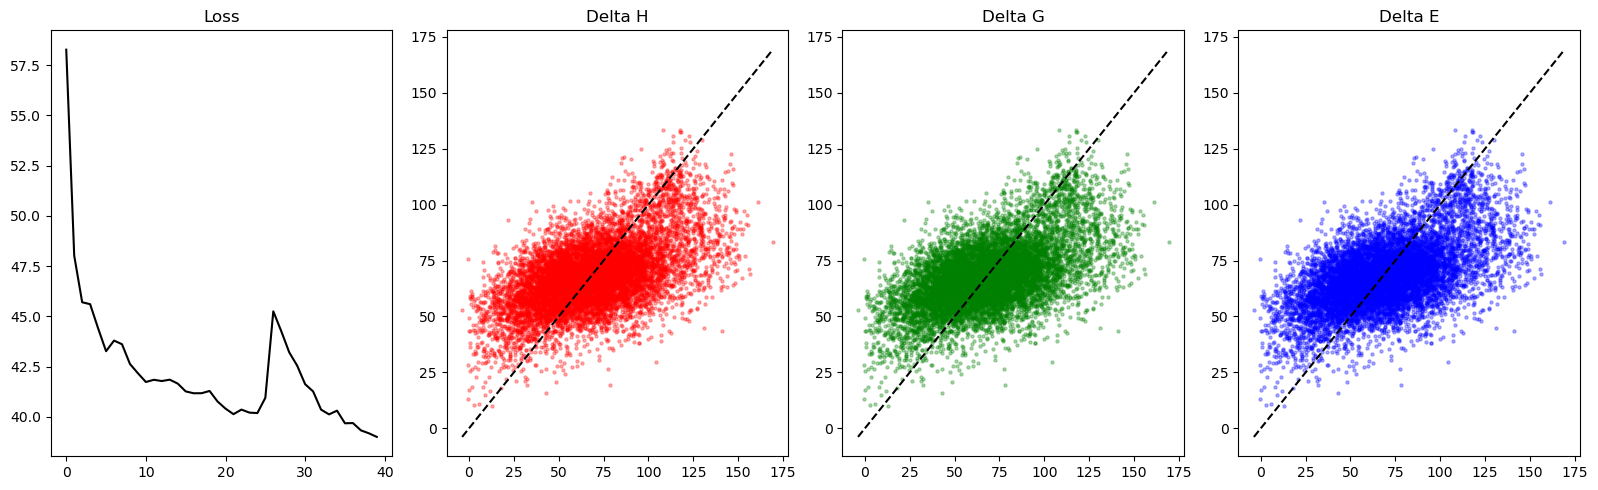

In [41]:
if __name__ == "__main__":
    import os
    base_dir = r"C:\Users\ansh1\OneDrive\OneDrive - personal\서류&파일\University of Seoul\연구\Code"
    MY_H5_PATH = os.path.join(base_dir, "RGD1_CHNO.h5")
    
    if os.path.exists(MY_H5_PATH):
        hist, r_E3, p_E3 = train(MY_H5_PATH, epochs=40, limit=10000)
        
        if hist:
            plt.figure(figsize=(16, 5))
            plt.subplot(1, 4, 1); plt.plot(hist['loss'], 'k-'); plt.title("Loss")
            titles, colors = ["Delta H", "Delta G", "Delta E"], ['r', 'g', 'b']
            keys = ['H', 'G', 'E']
            for i, k in enumerate(keys):
                plt.subplot(1, 4, i+2)
                plt.scatter(r_E3[k], p_E3[k], alpha=0.3, color=colors[i], s=5)
                mx = max(max(r_E3[k]), max(p_E3[k]))
                mn = min(min(r_E3[k]), min(p_E3[k]))
                plt.plot([mn, mx], [mn, mx], 'k--')
                plt.title(titles[i])
            plt.tight_layout()
            plt.show()
    else:
        print("파일을 찾을 수 없습니다.")

In [42]:
import numpy as np

def print_evaluation_report(real_dict, pred_dict):
    """
    학습 결과(정답 vs 예측)를 받아서 MAE, RMSE, R2, MSE를 계산하고 출력합니다.
    """
    print("\n" + "="*75)
    print(f"   📊 FINAL PHYSICS-INFORMED MODEL PERFORMANCE REPORT (kcal/mol)")
    print("="*75)

    # 헤더 출력
    header = f"{'Energy Type':<15} | {'MAE':<10} | {'RMSE':<10} | {'MSE':<10} | {'R² Score':<10}"
    print(header)
    print("-" * 75)

    # H, G, E 각각에 대해 계산
    metrics = {}
    for key in ['H', 'G', 'E']:
        y_true = np.array(real_dict[key])
        y_pred = np.array(pred_dict[key])

        # 1. MAE (Mean Absolute Error)
        mae = np.mean(np.abs(y_true - y_pred))

        # 2. MSE (Mean Squared Error)
        mse = np.mean((y_true - y_pred)**2)

        # 3. RMSE (Root Mean Squared Error)
        rmse = np.sqrt(mse)

        # 4. R2 Score (Coefficient of Determination)
        ss_res = np.sum((y_true - y_pred)**2)
        ss_tot = np.sum((y_true - np.mean(y_true))**2)
        r2 = 1 - (ss_res / (ss_tot + 1e-8)) # 0으로 나누기 방지

        # 결과 저장
        metrics[key] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}

        # 행 출력
        label = f"Delta {key} (Δ{key})"
        print(f"{label:<15} | {mae:<10.4f} | {rmse:<10.4f} | {mse:<10.4f} | {r2:<10.4f}")

    print("="*75)

    # [화학적 해석]
    # 화학적 정확도(Chemical Accuracy)는 보통 1 kcal/mol 이내를 말합니다.
    avg_mae = np.mean([metrics[k]['MAE'] for k in ['H', 'G', 'E']])
    print(f"⭐ Average MAE: {avg_mae:.4f} kcal/mol")

    if avg_mae < 2.5:
        print("✅ 모델이 물리 법칙(BEP, Hammond, Pauling)을 매우 잘 학습했습니다!")
        print("   (일반적인 DFT 계산 오차가 2~3 kcal/mol 수준임을 감안하면 훌륭합니다.)")
    elif avg_mae < 5.0:
        print("⚠️ 학습이 잘 되었으나, 일부 복잡한 반응에서 오차가 있습니다.")
    else:
        print("❌ 아직 과소적합 상태이거나 물리적 제약 조건이 더 필요합니다.")
    print("="*75 + "\n")

# ==============================================================================
# [실행 방법] main 블록 안에서 train()이 끝난 후 호출하세요
# ==============================================================================
if __name__ == "__main__":
    # 위에서 이미 train을 실행해서 r_E3, p_E3가 있다고 가정합니다.
    # 만약 변수가 메모리에 없다면 다시 학습을 돌려야 합니다.

    if 'r_E3' in locals() and 'p_E3' in locals():
        print_evaluation_report(r_E3, p_E3)
    else:
        print("먼저 train() 함수를 실행하여 r_E3, p_E3 변수를 생성해주세요.")


   📊 FINAL PHYSICS-INFORMED MODEL PERFORMANCE REPORT (kcal/mol)
Energy Type     | MAE        | RMSE       | MSE        | R² Score  
---------------------------------------------------------------------------
Delta H (ΔH)    | 18.5884    | 23.4467    | 549.7500   | 0.3086    
Delta G (ΔG)    | 18.5884    | 23.4467    | 549.7500   | 0.3086    
Delta E (ΔE)    | 18.5884    | 23.4467    | 549.7500   | 0.3086    
⭐ Average MAE: 18.5884 kcal/mol
❌ 아직 과소적합 상태이거나 물리적 제약 조건이 더 필요합니다.

